In [49]:
import shap
print(shap.__version__)

0.45.1


In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
# print elasticsearch search package version
import elasticsearch
print(elasticsearch.__version__)

(8, 13, 2)


In [52]:
from elasticsearch import Elasticsearch, helpers
import time

# 1. Connect to ES (edit the host/port as needed)
es = Elasticsearch("http://localhost:9200")
index_name = "bm25-demo"

# 2. Delete index if it exists (for repeatable demo)
if es.indices.exists(index=index_name):
    es.indices.delete(index=index_name)

# 3. Create index with BM25 (standard analyzer by default)
mapping = {

    "mappings": {
        "properties": {
            "content": {
                "type": "text",  # Uses BM25 and standard analyzer by default
            }
        }
    }
}
es.indices.create(index=index_name, body=mapping)
print(f"Created index '{index_name}'.")

# 4. Index a few documents
docs = [
    {"content": "The stock market saw gains today in the finance sector."},
    {"content": "Technology advances are happening at a rapid pace."},
    {"content": "Healthy eating and exercise improve overall health."},
    {"content": "Weather forecasts predict rain this week."},
    {"content": "Financial experts recommend saving early for retirement."},
]
actions = [{"_index": index_name, "_source": doc} for doc in docs]
helpers.bulk(es, actions)
print("Indexed documents.")
time.sleep(1)  # Let ES index the docs



import sys
sys.path.append('/Users/keqiaoli/Desktop/RankingSHAP/RankingShap/')
# import rankingSHAP_test_class_cutomized
from rankingSHAP_test_class_cutomized import extract_es_features_optimized, extract_features_from_documents 
# from rankingSHAP_test_class import extract_es_features_optimized
# ----- Usage -----
es = Elasticsearch("http://localhost:9200")
index_name = "bm25-demo"

# Extract features using the optimized method
features = extract_es_features_optimized(es, index_name, field="content")
print(features)
print(len(features))








Created index 'bm25-demo'.
Indexed documents.
['a', 'advances', 'and', 'are', 'at', 'early', 'eating', 'exercise', 'experts', 'finance', 'financial', 'for', 'forecasts', 'gains', 'happening', 'health', 'healthy', 'improve', 'in', 'market', 'overall', 'pace', 'predict', 'rain', 'rapid', 'recommend', 'retirement', 'saving', 'saw', 'sector', 'stock', 'technology', 'the', 'this', 'today', 'weather', 'week']
37


In [53]:
import random

documents = [
    "The stock market saw gains today in the finance sector.",
    "Technology advances are happening at a rapid pace.",
    "Healthy eating and exercise improve overall health.",
    "Weather forecasts predict rain this week.",
    "Financial experts recommend saving early for retirement.",
    "Machine learning models require large datasets for training.",
    "The weather today is sunny and warm.",
    "Exercise and diet are key to maintaining good health."
]

finance_variations = [
    "The stock market saw slight losses today in the tech sector.",
    "Investors showed optimism in the banking industry this morning.",
    "Financial analysts expect interest rates to rise next quarter.",
    "The bond market remained steady amid economic uncertainty."
]

tech_variations = [
    "New breakthroughs in AI are transforming industries rapidly.",
    "Advances in robotics and automation continue to accelerate.",
    "Quantum computing shows promise for solving complex problems.",
    "Tech startups are innovating at an unprecedented pace."
]

health_variations = [
    "Regular exercise and balanced nutrition enhance physical fitness.",
    "Maintaining a healthy diet reduces risk of chronic diseases.",
    "Sleep and hydration play a key role in wellness.",
    "Mental health awareness is becoming increasingly important."
]

weather_variations = [
    "Meteorologists predict heavy snowfall this weekend.",
    "A heatwave is expected to hit the southern region soon.",
    "Storm warnings have been issued for coastal areas.",
    "Temperatures are expected to remain mild throughout the week."
]

ml_variations = [
    "Deep learning models rely heavily on high-quality labeled data.",
    "AI models often require fine-tuning to achieve optimal accuracy.",
    "Model performance depends greatly on data preprocessing.",
    "Training neural networks demands substantial computational resources."
]

all_templates = finance_variations + tech_variations + health_variations + weather_variations + ml_variations + documents

# random combination to make 100 records
synthetic_documents = [random.choice(all_templates) for _ in range(100)]
print(len(synthetic_documents))
# for i, doc in enumerate(synthetic_documents[:10], 1):  # print first 10 for preview
#     print(f"{i}. {doc}")

# # print(f"\nTotal records generated: {len(synthetic_documents)}")


100


In [54]:
from elasticsearch import Elasticsearch, helpers
from typing import List, Dict, Any, Optional
import uuid

class ElasticsearchSparseSearchModel:
    """
    A simple Elasticsearch sparse search model with scikit-learn-like interface.
    Uses BM25 scoring for sparse retrieval.
    """
    
    def __init__(self, es_host: str = "http://localhost:9200", index_name: Optional[str] = None):
        """
        Initialize the Elasticsearch sparse search model.
        
        Args:
            es_host (str): Elasticsearch host URL
            index_name (str, optional): Index name. If None, generates a random one.
        """
        self.es_host = es_host
        self.index_name = index_name or f"sparse_search_{uuid.uuid4().hex[:8]}"
        self.es = None
        self.is_fitted = False
        self.field_name = "content"
        
    def _connect(self):
        """Establish connection to Elasticsearch."""
        if self.es is None:
            try:
                self.es = Elasticsearch(self.es_host)
                if not self.es.ping():
                    raise ConnectionError("Cannot connect to Elasticsearch")
                print(f"Connected to Elasticsearch at {self.es_host}")
            except Exception as e:
                raise ConnectionError(f"Failed to connect to Elasticsearch: {e}")
    
    def fit(self, documents: List[str]) -> 'ElasticsearchSparseSearchModel':
        """
        Fit the model by indexing documents into Elasticsearch.
        
        Args:
            documents (List[str]): List of document texts to index
            
        Returns:
            self: Returns the instance for method chaining
        """
        self._connect()
        
        # Delete existing index if it exists
        if self.es.indices.exists(index=self.index_name):
            self.es.indices.delete(index=self.index_name)
            print(f"Deleted existing index '{self.index_name}'")
        
        # Create index with BM25 settings
        mapping = {
            "mappings": {
                "properties": {
                    self.field_name: {
                        "type": "text",
                        "analyzer": "english"  # Uses BM25 by default
                    }
                }
            }
        }
        
        try:
            self.es.indices.create(index=self.index_name, **mapping)
            print(f"Created index '{self.index_name}'")
        except Exception as e:
            raise RuntimeError(f"Failed to create index: {e}")
        
        # Index documents
        actions = []
        for i, doc in enumerate(documents):
            actions.append({
                "_index": self.index_name,
                "_id": i,
                "_source": {self.field_name: doc}
            })
        
        try:
            helpers.bulk(self.es, actions)
            self.es.indices.refresh(index=self.index_name)
            print(f"Indexed {len(documents)} documents")
            self.is_fitted = True
        except Exception as e:
            raise RuntimeError(f"Failed to index documents: {e}")
        
        return self
    
    def predict(self, queries: List[str], top_k: int = 5) -> List[List[Dict[str, Any]]]:
        """
        Perform sparse search predictions for given queries.
        
        Args:
            queries (List[str]): List of query strings
            top_k (int): Number of top results to return per query
            
        Returns:
            List[List[Dict]]: For each query, returns list of top_k results.
                            Each result contains: {'doc_id', 'score', 'content'}
        """
        if not self.is_fitted:
            raise RuntimeError("Model must be fitted before making predictions. Call .fit() first.")
        
        results = []
        
        for query in queries:
            # Elasticsearch query using BM25
            search_body = {
                "query": {
                    "match": {
                        self.field_name: query
                    }
                },
                "size": top_k,
                "_source": [self.field_name]
            }
            
            try:
                response = self.es.search(index=self.index_name, body=search_body)
                
                query_results = []
                for hit in response['hits']['hits']:
                    result = {
                        'doc_id': hit['_id'],
                        'score': hit['_score'],
                        'content': hit['_source'][self.field_name]
                    }
                    query_results.append(result)
                
                results.append(query_results)
                
            except Exception as e:
                print(f"Error searching for query '{query}': {e}")
                results.append([])  # Return empty results on error
        
        return results
    
    def predict_single(self, query: str, top_k: int = 5) -> List[Dict[str, Any]]:
        """
        Convenience method for single query prediction.
        
        Args:
            query (str): Single query string
            top_k (int): Number of top results to return
            
        Returns:
            List[Dict]: List of top_k results for the query
        """
        results = self.predict([query], top_k)
        return results[0] if results else []
    
    def cleanup(self):
        """Delete the index and clean up resources."""
        if self.es and self.es.indices.exists(index=self.index_name):
            self.es.indices.delete(index=self.index_name)
            print(f"Deleted index '{self.index_name}'")

    def extract_features(self) -> Optional[Any]:
        """
        Extract features using RankingSHAP from the indexed documents.
        
        Returns:
            features: Extracted features or None if extraction fails
        """
        if not self.is_fitted:
            raise RuntimeError("Model must be fitted before extracting features. Call .fit() first.")
        
        try:
            from rankingSHAP_test_class_cutomized import extract_es_features_optimized
            features = extract_es_features_optimized(self.es, self.index_name, field=self.field_name)
            return features
        except ImportError as e:
            print(f"Import error: {e}")
            print("Please check the path to your RankingSHAP module")
            return None
        except Exception as e:
            print(f"Error extracting features: {e}")
            return None

# # Sample documents
# documents = [
#     "The stock market saw gains today in the finance sector.",
#     "Technology advances are happening at a rapid pace.",
#     "Healthy eating and exercise improve overall health.",
#     "Weather forecasts predict rain this week.",
#     "Financial experts recommend saving early for retirement.",
#     "Machine learning models require large datasets for training.",
#     "The weather today is sunny and warm.",
#     "Exercise and diet are key to maintaining good health."
# ]
documents = synthetic_documents.copy()

# Create and fit the model
model = ElasticsearchSparseSearchModel()
# Fit the model
print("Fitting model with documents...")
model.fit(documents)
features = model.extract_features()
print(features)
print(len(features))




Fitting model with documents...
Connected to Elasticsearch at http://localhost:9200
Created index 'sparse_search_5bdfd3fe'
Indexed 100 documents
['acceler', 'accuraci', 'achiev', 'advanc', 'ai', 'amid', 'analyst', 'area', 'autom', 'awar', 'balanc', 'bank', 'becom', 'been', 'bond', 'breakthrough', 'chronic', 'coastal', 'complex', 'comput', 'continu', 'data', 'dataset', 'deep', 'demand', 'depend', 'diet', 'diseas', 'earli', 'eat', 'econom', 'enhanc', 'exercis', 'expect', 'expert', 'financ', 'financi', 'fine', 'fit', 'forecast', 'gain', 'good', 'greatli', 'happen', 'have', 'health', 'healthi', 'heatwav', 'heavi', 'heavili', 'high', 'hit', 'hydrat', 'import', 'improv', 'increasingli', 'industri', 'innov', 'interest', 'investor', 'issu', 'kei', 'label', 'larg', 'learn', 'loss', 'machin', 'maintain', 'market', 'mental', 'meteorologist', 'model', 'morn', 'network', 'neural', 'new', 'next', 'nutrit', 'often', 'optim', 'overal', 'pace', 'perform', 'physic', 'plai', 'predict', 'preprocess', 'pro

In [119]:
from utils.get_explanations import calculate_all_query_explanations
from utils.helper_functions import get_data
import lightgbm
import numpy as np
from scipy.stats import kendalltau
from utils.background_data import BackgroundData
from approaches.ranking_shap import RankingShap
from approaches.ranking_lime import RankingLIME
from approaches.greedy_listwise import GreedyListwise
from approaches.pointwise_lime import AggregatedLime
from approaches.pointwise_shap import AggregatedShap
from approaches.random_explainer import RandomExplainer
from pathlib import Path


explanation_size = 1000


num_features = len(features)
print(num_features)
background_data_new = np.full((1, num_features), '<unk>', dtype=object)
background_data_new

139


array([['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
      

In [120]:
documents

['Deep learning models rely heavily on high-quality labeled data.',
 'Technology advances are happening at a rapid pace.',
 'Advances in robotics and automation continue to accelerate.',
 'The bond market remained steady amid economic uncertainty.',
 'Investors showed optimism in the banking industry this morning.',
 'Weather forecasts predict rain this week.',
 'AI models often require fine-tuning to achieve optimal accuracy.',
 'Training neural networks demands substantial computational resources.',
 'Sleep and hydration play a key role in wellness.',
 'Healthy eating and exercise improve overall health.',
 'Mental health awareness is becoming increasingly important.',
 'Financial experts recommend saving early for retirement.',
 'Machine learning models require large datasets for training.',
 'The stock market saw slight losses today in the tech sector.',
 'The stock market saw gains today in the finance sector.',
 'Model performance depends greatly on data preprocessing.',
 'Storm 

In [121]:
import sparse_search_bm25 as sparse_search_bm25
import importlib
importlib.reload(sparse_search_bm25)
import json

from sparse_search_bm25 import BM25SearchEngine, demo_bm25_search

documents = list(set(documents))
print(len(documents))
query = "What is new in stock market?"
preds = demo_bm25_search(query,
                 documents)

27
Indexed 27 documents


In [122]:
preds[:5]

[{'_score': 5.0204769558105395,
  '_source': 'The stock market saw gains today in the finance sector.',
  '_index': 14},
 {'_score': 4.801017358713587,
  '_source': 'The stock market saw slight losses today in the tech sector.',
  '_index': 13},
 {'_score': 4.113410350132243,
  '_source': 'New breakthroughs in AI are transforming industries rapidly.',
  '_index': 17},
 {'_score': 2.0719043313682475,
  '_source': 'Mental health awareness is becoming increasingly important.',
  '_index': 10},
 {'_score': 2.0719043313682475,
  '_source': 'The weather today is sunny and warm.',
  '_index': 18}]

In [123]:
len(preds)

27

In [198]:




# import approaches.ranking_shap as ranking_shap_module
import importlib
from approaches import ranking_shap_decoupled_test_v1

importlib.reload(ranking_shap_decoupled_test_v1)
from approaches.ranking_shap_decoupled_test_v1 import RankingShapDecoupled

# Now use it with the module prefix
# approaches.ranking_shap_decoupled.your_function()

# from approaches.ranking_shap import RankingShap

import rbo
safe_attributions_to = '/Users/keqiaoli/Desktop/RankingSHAP/RankingShap/test_results.csv'


# rank_similarity_coefficient = lambda x, y: rbo.RankingSimilarity(x, y)
rank_similarity_coefficient = lambda x, y: kendalltau(x, y)[0]
# Define all the explainers
ranking_shap_explainer = RankingShapDecoupled(
    permutation_sampler="kernel",
    background_data=background_data_new,
    original_model=demo_bm25_search,
    explanation_size=5, 
    rank_similarity_coefficient=rank_similarity_coefficient,
    nsample_permutations= 3000
)

# feature_attribution = ranking_shap_explainer.get_query_explanation(
#     query_features=features, documents = documents, query = query
# )

# feature_attribution.safe_to_file(safe_attributions_to)
# features_selection, feature_attribution = ranking_shap_explainer.get_query_explanation(
#     query_features=features, documents = documents, query_id=""
# )

# all_masks = ranking_shap_explainer.all_masks
# print(np.array(all_masks).shape)
# print(all_masks)


Using kernel weight mode: binom


In [199]:
masks, metadata = ranking_shap_explainer.generate_masks_only(features, 
                                           query_id= "123")

Generating masks for query: 123
Query features: ['acceler', 'accuraci', 'achiev', 'advanc', 'ai', 'amid', 'analyst', 'area', 'autom', 'awar', 'balanc', 'bank', 'becom', 'been', 'bond', 'breakthrough', 'chronic', 'coastal', 'complex', 'comput', 'continu', 'data', 'dataset', 'deep', 'demand', 'depend', 'diet', 'diseas', 'earli', 'eat', 'econom', 'enhanc', 'exercis', 'expect', 'expert', 'financ', 'financi', 'fine', 'fit', 'forecast', 'gain', 'good', 'greatli', 'happen', 'have', 'health', 'healthi', 'heatwav', 'heavi', 'heavili', 'high', 'hit', 'hydrat', 'import', 'improv', 'increasingli', 'industri', 'innov', 'interest', 'investor', 'issu', 'kei', 'label', 'larg', 'learn', 'loss', 'machin', 'maintain', 'market', 'mental', 'meteorologist', 'model', 'morn', 'network', 'neural', 'new', 'next', 'nutrit', 'often', 'optim', 'overal', 'pace', 'perform', 'physic', 'plai', 'predict', 'preprocess', 'problem', 'promis', 'qualiti', 'quantum', 'quarter', 'rain', 'rapid', 'rapidli', 'rate', 'recommend'

100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

Masks saved to: rankingshap_outputs/masks_123.npz
Metadata saved to: rankingshap_outputs/masks_123_metadata.json
Generated 3001 masks


In [200]:
masks

array([['<keep>', '<keep>', '<keep>', ..., '<keep>', '<keep>', '<keep>'],
       ['<keep>', '<unk>', '<unk>', ..., '<unk>', '<unk>', '<unk>'],
       ['<unk>', '<keep>', '<keep>', ..., '<keep>', '<keep>', '<keep>'],
       ...,
       ['<unk>', '<keep>', '<keep>', ..., '<keep>', '<keep>', '<keep>'],
       ['<unk>', '<unk>', '<keep>', ..., '<unk>', '<unk>', '<unk>'],
       ['<keep>', '<keep>', '<unk>', ..., '<keep>', '<keep>', '<keep>']],
      dtype=object)

In [201]:
import os
# timestamp = "20251014_231705"
masks_file = os.path.join("rankingshap_outputs", f"masks_123.npz")

perturbed_results = ranking_shap_explainer.apply_masks_to_documents(masks_file,
                                                documents,
                                                query = query,
                                                output_filename=f"perturbed_data_123.npz")

Loaded 3001 masks from rankingshap_outputs/masks_123.npz
Query features: ['acceler', 'accuraci', 'achiev', 'advanc', 'ai', 'amid', 'analyst', 'area', 'autom', 'awar', 'balanc', 'bank', 'becom', 'been', 'bond', 'breakthrough', 'chronic', 'coastal', 'complex', 'comput', 'continu', 'data', 'dataset', 'deep', 'demand', 'depend', 'diet', 'diseas', 'earli', 'eat', 'econom', 'enhanc', 'exercis', 'expect', 'expert', 'financ', 'financi', 'fine', 'fit', 'forecast', 'gain', 'good', 'greatli', 'happen', 'have', 'health', 'healthi', 'heatwav', 'heavi', 'heavili', 'high', 'hit', 'hydrat', 'import', 'improv', 'increasingli', 'industri', 'innov', 'interest', 'investor', 'issu', 'kei', 'label', 'larg', 'learn', 'loss', 'machin', 'maintain', 'market', 'mental', 'meteorologist', 'model', 'morn', 'network', 'neural', 'new', 'next', 'nutrit', 'often', 'optim', 'overal', 'pace', 'perform', 'physic', 'plai', 'predict', 'preprocess', 'problem', 'promis', 'qualiti', 'quantum', 'quarter', 'rain', 'rapid', 'rapi

In [202]:
len(perturbed_results)

3001

(array([431., 141.,  95.,  67.,  54.,  46.,  36.,  50.,  43.,  34.,  38.,
         40.,  48.,  33.,  49.,  51.,  64.,  91., 127., 462.]),
 array([  0. ,   6.9,  13.8,  20.7,  27.6,  34.5,  41.4,  48.3,  55.2,
         62.1,  69. ,  75.9,  82.8,  89.7,  96.6, 103.5, 110.4, 117.3,
        124.2, 131.1, 138. ]),
 <BarContainer object of 20 artists>)

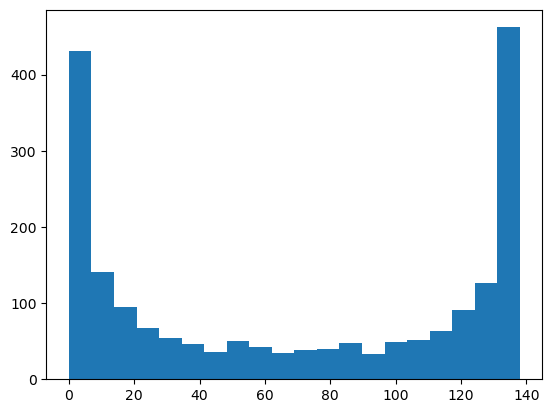

In [203]:
num_masked = []
for mask_index in range(2000):
    # mask = perturbed_results[mask_index][0]
    num_masked.append(len(perturbed_results[mask_index][2]['words_replaced']))

import matplotlib.pyplot as plt
plt.hist(num_masked, bins=20)

In [204]:
perturbed_docs = perturbed_results[mask_index][1]
perturbed_docs

['<unk> <unk> <unk> rely <unk> on <unk>-<unk> <unk> <unk>.',
 '<unk> <unk> are <unk> at a <unk> <unk>.',
 '<unk> in <unk> and automation <unk> to accelerate.',
 'The <unk> <unk> <unk> steady <unk> <unk> <unk>.',
 '<unk> forecasts <unk> <unk> this week.',
 '<unk> showed <unk> in the <unk> <unk> this <unk>.',
 'AI <unk> <unk> <unk> <unk>-tuning to <unk> <unk> <unk>.',
 '<unk> <unk> <unk> <unk> <unk> <unk> <unk>.',
 '<unk> and hydration play a key <unk> in <unk>.',
 'Healthy <unk> and exercise <unk> overall <unk>.',
 'Mental <unk> <unk> is <unk> <unk> <unk>.',
 'Financial <unk> recommend <unk> <unk> for retirement.',
 '<unk> <unk> <unk> <unk> <unk> datasets for <unk>.',
 'The <unk> <unk> <unk> slight <unk> today in the tech sector.',
 'The <unk> <unk> <unk> <unk> today in the <unk> sector.',
 '<unk> <unk> <unk> greatly on <unk> preprocessing.',
 '<unk> warnings <unk> been <unk> for <unk> areas.',
 '<unk> <unk> in AI are <unk> <unk> <unk>.',
 'The <unk> today is <unk> and warm.',
 '<unk> <

In [205]:
perturbed_data_filepath = os.path.join("/Users/keqiaoli/Desktop/RankingSHAP/RankingShap/rankingshap_outputs", 
                                       f"perturbed_data_123.npz")

data = np.load(perturbed_data_filepath, allow_pickle=True)


perturbed_data_filepath


'/Users/keqiaoli/Desktop/RankingSHAP/RankingShap/rankingshap_outputs/perturbed_data_123.npz'

In [206]:
# for i in range(len(data["perturbed_data"])):
#     print(i, data["perturbed_data"][i]['perturbation_info']['similarity_score'])



In [207]:
# masks = []
# scores = []
# for item in data["perturbed_data"]:
#     masks.append(np.array(item['mask']))
#     scores.append(item['perturbation_info']['similarity_score'])

In [208]:
# perturbed_data_list = data["perturbed_data"]
# for item in perturbed_data_list:
#     masks.append(np.array(item['mask']))
#     scores.append(item['perturbation_info']['similarity_score'])

In [209]:
len(features)

139

In [210]:
len(features)

139

In [211]:
explanation_output = ranking_shap_explainer.calculate_shap_from_perturbed(
    perturbed_data_filepath,
    features,
    query_id ="123"
)

Calculating SHAP values from: /Users/keqiaoli/Desktop/RankingSHAP/RankingShap/rankingshap_outputs/perturbed_data_123.npz
Loaded 3001 precomputed mask-score pairs
Using kernel weight method: binom


In [213]:
explanation_output.safe_to_file('/Users/keqiaoli/Desktop/RankingSHAP/RankingShap/test_results_v1.csv')

Writing to  /Users/keqiaoli/Desktop/RankingSHAP/RankingShap/test_results_v1.csv


In [ ]:
# pip install rank_bm25
from rank_bm25 import BM25Okapi

# 1. Prepare corpus
corpus = [
    "BM25 is a ranking function used by search engines.",
    "Elasticsearch uses BM25 as its default similarity algorithm.",
    "BM25Okapi is a Python implementation for text retrieval.",
    "This document talks about cooking pasta."
]

# 2. Tokenize (very basic split)
tokenized_corpus = [doc.lower().split() for doc in corpus]

# 3. Build BM25 model
bm25 = BM25Okapi(tokenized_corpus)

# 4. Query
query = "bm25 ranking algorithm".lower().split()

# 5. Get scores
scores = bm25.get_scores(query)

# 6. Sort and print top results
for idx in sorted(range(len(scores)), key=lambda i: scores[i], reverse=True):
    print(f"Doc {idx} | Score: {scores[idx]:.3f} | Text: {corpus[idx]}")


In [54]:
words_replaced = perturbed_results[1][2]['words_replaced']
print(words_replaced)

mask = perturbed_results[1][0]
mask

['technolog', 'gain', 'weather', 'maintain', 'stock', 'healthi', 'train', 'diet', 'happen', 'retir', 'improv', 'learn', 'saw', 'pace', 'good', 'model', 'eat', 'requir', 'health', 'expert', 'exercis', 'rapid', 'sector', 'overal', 'dataset', 'earli', 'market', 'week', 'financi', 'machin', 'larg', 'kei', 'rain', 'forecast', 'sunni', 'save', 'warm', 'recommend', 'todai']


array(['<keep>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
       '<keep>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
       '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
       '<unk>', '<unk>', '<unk>', '<unk>', '<keep>', '<unk>', '<unk>',
       '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
       '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'],
      dtype=object)

In [53]:
perturbed_docs = perturbed_results[1][1]
perturbed_docs

['The <unk> <unk> <unk> <unk> today in the <unk> <unk>.',
 '<unk> advances are <unk> at a <unk> <unk>.',
 '<unk> <unk> and exercise <unk> overall <unk>.',
 '<unk> <unk> predict <unk> this <unk>.',
 'Financial <unk> <unk> <unk> <unk> for <unk>.',
 '<unk> <unk> <unk> <unk> <unk> <unk> for <unk>.',
 'The <unk> today is <unk> and <unk>.',
 'Exercise and <unk> are key to <unk> <unk> <unk>.']

In [ ]:
perturbed_results[2][-1]['words_replaced']

In [44]:
perturbed_results[2][-1]['words_replaced']

['predict', 'advanc', 'financ']

In [6]:
# import approaches.ranking_shap as ranking_shap_module
# import importlib
# importlib.reload(ranking_shap_module)

# from approaches.ranking_shap import RankingShap




# rank_similarity_coefficient = lambda x, y: kendalltau(x, y)[0]

# # Define all the explainers
# ranking_shap_explainer = RankingShap(
#     permutation_sampler="kernel",
#     background_data=background_data_new,
#     original_model=model.predict,
#     explanation_size=3,
#     name="rankingshap",
#     rank_similarity_coefficient=rank_similarity_coefficient,
# )

# features_selection, feature_attribution = ranking_shap_explainer.get_query_explanation(
#     query_features=features, query_id="12345"
# )


Indexed 8 documents

Query: 'What is new in stock market?'

1. Score: 4.3157

2. Score: 1.6758

3. Score: 0.0000


In [12]:
def rank_list(preds):
    """
    returns ndarray containing rank(i) for documents at position i
    """
    vector = np.array([pred['_score'] for pred in preds])
    temp = vector.argsort()[::-1]
    ranks = np.empty_like(temp)
    ranks[temp] = np.arange(1, len(vector) + 1)

    return ranks

In [13]:
rank_list(preds)

array([1, 2, 3])

  0%|          | 0/1 [00:00<?, ?it/s]

array================>: [['<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>'
  '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>'
  '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>'
  '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>'
  '<keep>' '<keep>' '<keep>' '<keep>' '<keep>']]
(1, 37)
==========> code goes here !!!!!
Query: What is new in stock market?
<function demo_bm25_search at 0x1780e2950>
Indexed 3 documents

Query: 'What is new in stock market?'

1. Score: 1.4166

2. Score: 0.0000

3. Score: 0.0000
Original rank: [1 3 2]

Mask 0: replaced_with_unk = set()
Indexed 3 documents

Query: 'What is new in stock market?'

1. Score: 1.4166

2. Score: 0.0000

3. Score: 0.0000
New rank for mask 0: [1 3 2]
[1.0]
array================>: [['<keep>' '<unk>' '<unk>' ... '<unk>' '<unk>' '<unk>']
 ['<unk>' '<keep>' '<keep>' ... '<keep>' '<keep>' '<keep>']
 ['<unk>' '<keep>' '<unk>' ... '<unk>' '<unk>' '<unk

100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


1. Score: 0.0000

2. Score: 0.0000

3. Score: 0.0000
New rank for mask 668: [3 2 1]

Mask 669: replaced_with_unk = {'today', 'gains', 'health'}
Indexed 3 documents

Query: 'What is new in stock market?'

1. Score: 1.4166

2. Score: 0.0000

3. Score: 0.0000
New rank for mask 669: [1 3 2]

Mask 670: replaced_with_unk = {'eating', 'and', 'health', 'finance', 'market', 'predict', 'stock', 'the', 'saw', 'this', 'today', 'experts', 'gains', 'happening', 'week', 'rain', 'saving', 'early', 'at', 'retirement', 'healthy', 'pace', 'forecasts', 'exercise', 'are', 'weather', 'a', 'improve', 'advances', 'rapid'}
Indexed 3 documents

Query: 'What is new in stock market?'

1. Score: 0.4722

2. Score: 0.0000

3. Score: 0.0000
New rank for mask 670: [1 3 2]

Mask 671: replaced_with_unk = {'sector', 'for', 'technology', 'financial', 'overall', 'recommend', 'in'}
Indexed 3 documents

Query: 'What is new in stock market?'

1. Score: 0.9444

2. Score: 0.0000

3. Score: 0.0000
New rank for mask 671: [1 3 2]

In [13]:
len(features), documents

(42,
 ['The stock market saw gains today in the finance sector.',
  'Technology advances are happening at a rapid pace.',
  'Healthy eating and exercise improve overall health.',
  'Weather forecasts predict rain this week.',
  'Financial experts recommend saving early for retirement.',
  'Machine learning models require large datasets for training.',
  'The weather today is sunny and warm.',
  'Exercise and diet are key to maintaining good health.'])

In [ ]:
import approaches.ranking_shap as ranking_shap_module
import importlib
importlib.reload(ranking_shap_module)

from approaches.ranking_shap import RankingShap
import rbo
safe_attributions_to = '/Users/keqiaoli/Desktop/RankingSHAP/RankingShap/test_results.csv'


rank_similarity_coefficient = lambda x, y: rbo.RankingSimilarity(x, y)

# Define all the explainers
ranking_shap_explainer = RankingShap(
    permutation_sampler="kernel",
    background_data=background_data_new,
    original_model=demo_bm25_search,
    explanation_size=20,
    name="rankingshap",
    rank_similarity_coefficient=rank_similarity_coefficient,
    nsample_permutations=500
)

feature_attribution = ranking_shap_explainer.get_query_explanation(
    query_features=features, documents = documents, query = "query"
)

# feature_attribution.safe_to_file(safe_attributions_to)
# features_selection, feature_attribution = ranking_shap_explainer.get_query_explanation(
#     query_features=features, documents = documents, query_id=""
# )

# all_masks = ranking_shap_explainer.all_masks
# print(np.array(all_masks).shape)
# print(all_masks)


100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

array================>: [['<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>'
  '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>'
  '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>'
  '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>'
  '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>' '<keep>'
  '<keep>' '<keep>']]
(1, 42)
==========> code goes here !!!!!
Query: query
<function demo_bm25_search at 0x30057ee60>
Indexed 8 documents

Query: 'query'

1. Score: 0.0000

2. Score: 0.0000

3. Score: 0.0000
Original rank: [3 2 1]

Mask 0: replaced_with_unk = set()
Indexed 8 documents

Query: 'query'

1. Score: 0.0000

2. Score: 0.0000

3. Score: 0.0000
New rank for mask 0: [3 2 1]
[1.0]
array================>: [['<keep>' '<unk>' '<unk>' ... '<unk>' '<unk>' '<unk>']
 ['<unk>' '<keep>' '<keep>' ... '<keep>' '<keep>' '<keep>']
 ['<unk>' '<unk>' '<keep>' ... '<unk>' '<keep>' '<unk>']
 ...
 ['<unk>' '<

In [13]:
ranking_shap_explainer.all_masks[1]

array(['<keep>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
       '<keep>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
       '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
       '<unk>', '<unk>', '<unk>', '<unk>', '<keep>', '<unk>', '<unk>',
       '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
       '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>'],
      dtype=object)

In [15]:
masks_list = masks.tolist()
masks_list == ranking_shap_explainer.all_masks

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [18]:
masks.tolist()

[['<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>',
  '<keep>'],
 ['<keep>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<keep>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<keep>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>',
  '<unk>'],
 ['<unk>',
  '<keep>',
  '<ke

In [24]:
all_masks_rankingshape = [ele.tolist() for ele in ranking_shap_explainer.all_masks]

(all_masks_rankingshape == masks).all()

True

In [30]:
# import re

# def replace_words_in_sentences(documents, words_to_replace, unk_token="<unk>", case_sensitive=False):
#     if not words_to_replace:
#         return documents
    
#     # Sort by length to match longer words first (avoids subword matching confusion)
#     sorted_words = sorted(words_to_replace, key=len, reverse=True)
#     # Escape special characters
#     escaped_words = [re.escape(w) for w in sorted_words]
#     # Build regex pattern: \b matches word boundaries (including punctuation)
#     pattern_str = r'\b(' + '|'.join(escaped_words) + r')\b'
#     flags = 0 if case_sensitive else re.IGNORECASE
#     pattern = re.compile(pattern_str, flags)
#     # Replace, preserving surrounding punctuation
#     return [pattern.sub(unk_token, sent) for sent in documents]

# # Example setup
# query_features = ["a", "red", "cat", "stock", "today"]
# array = [
#     ["<keep>", "<unk>", "<keep>", "<keep>", "<unk>"],
#     ["<unk>", "<unk>", "<keep>", "<unk>", "<keep>"]
# ]
# documents = [
#     "today, the RED| cat jumps over the stock",
#     "a red cat in the stock market",
#     "today is a good day for the cat"
# ]

# # For each mask
# for mask_idx, mask in enumerate(array):
#     replaced_with_unk = set(q for q, a in zip(query_features, mask) if a == "<unk>")
#     print(f"\nMask {mask_idx}: replaced_with_unk = {replaced_with_unk}")
#     new_docs = replace_words_in_sentences(documents, replaced_with_unk)
#     for sent in new_docs:
#         print(sent)


In [32]:
documents

['The stock market saw gains today in the finance sector.',
 'Technology advances are happening at a rapid pace.',
 'Healthy eating and exercise improve overall health.',
 'Weather forecasts predict rain this week.',
 'Financial experts recommend saving early for retirement.',
 'Machine learning models require large datasets for training.',
 'The weather today is sunny and warm.',
 'Exercise and diet are key to maintaining good health.']

In [37]:
docuemnts

NameError: name 'docuemnts' is not defined

In [42]:
background_data_new

array([['<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>',
        '<unk>', '<unk>']], dtype=object)

In [21]:
import approaches.ranking_shap as ranking_shap_module
import importlib
importlib.reload(ranking_shap_module)

from approaches.ranking_shap import RankingShap




rank_similarity_coefficient = lambda x, y: kendalltau(x, y)[0]

# Define all the explainers
ranking_shap_explainer = RankingShap(
    permutation_sampler="kernel",
    background_data=background_data_new,
    original_model=demo_bm25_search,
    explanation_size=20,
    name="rankingshap",
    rank_similarity_coefficient=rank_similarity_coefficient,
)

features_selection, feature_attribution = ranking_shap_explainer.get_query_explanation(
    query_features=features, documents = documents, query_id=""
)


TypeError: RankingShap.get_query_explanation() got an unexpected keyword argument 'query_id'

In [30]:
import re
def replace_words_in_sentences(
    documents, 
    words_to_replace, 
    unk_token="<unk>", 
    case_sensitive=False
):
    """
    Replace query words in documents for perturbation analysis.
    Optimized for ranking/retrieval use cases.
    """
    # Quick return for empty cases
    if not documents or not words_to_replace:
        return documents
    
    # Ensure set for performance
    words_set = set(words_to_replace) if not isinstance(words_to_replace, set) else words_to_replace
    words_set = {w.strip() for w in words_set if w and w.strip()}
    
    if not words_set:
        return documents
    
    # Sort by length (longest first to avoid partial matches)
    sorted_words = sorted(words_set, key=len, reverse=True)
    
    # Escape and build pattern
    escaped_words = [re.escape(w) for w in sorted_words]
    
    # Pattern explanation:
    # (?<!\w) - not preceded by word character
    # (...) - capture group with words to replace
    # (?!\w) - not followed by word character
    # This handles: "word ", "word.", "word,", "-word-", etc.
    pattern_str = r'(?<!\w)(' + '|'.join(escaped_words) + r')(?!\w)'
    
    flags = 0 if case_sensitive else re.IGNORECASE
    
    try:
        pattern = re.compile(pattern_str, flags)
    except re.error as e:
        print(f"Regex compilation error: {e}")
        print(f"Pattern: {pattern_str[:100]}...")
        return documents  # Return original on error
    
    # Replace in all documents
    return [pattern.sub(unk_token, doc) if isinstance(doc, str) else doc 
            for doc in documents]



def test_replace_words_in_sentences():
    """Test suite for replace_words_in_sentences"""
    
    # Test 1: Basic replacement
    docs = ["information retrieval system"]
    words = {"retrieval"}
    result = replace_words_in_sentences(docs, words)
    assert result == ["information <unk> system"], f"Test 1 failed: {result}"
    
    # Test 2: Multiple words
    docs = ["effective information retrieval"]
    words = {"information", "retrieval"}
    result = replace_words_in_sentences(docs, words)
    assert result == ["effective <unk> <unk>"], f"Test 2 failed: {result}"
    
    # Test 3: Case insensitive (default)
    docs = ["Information Retrieval System"]
    words = {"information", "retrieval"}
    result = replace_words_in_sentences(docs, words, case_sensitive=False)
    assert result == ["<unk> <unk> System"], f"Test 3 failed: {result}"
    
    # Test 4: With punctuation
    docs = ["information, retrieval, and search."]
    words = {"retrieval", "search"}
    result = replace_words_in_sentences(docs, words)
    assert result == ["information, <unk>, and <unk>."], f"Test 4 failed: {result}"
    
    # Test 5: Hyphenated text
    docs = ["state-of-the-art retrieval"]
    words = {"of", "the", "retrieval"}
    result = replace_words_in_sentences(docs, words)
    # Note: This tests whether hyphens are handled correctly
    print(f"Test 5 result: {result}")
    
    # Test 6: Subword protection
    docs = ["information informative"]
    words = {"information"}
    result = replace_words_in_sentences(docs, words)
    assert result == ["<unk> informative"], f"Test 6 failed: {result}"
    
    # Test 7: Empty words
    docs = ["information retrieval"]
    words = set()
    result = replace_words_in_sentences(docs, words)
    assert result == docs, f"Test 7 failed: {result}"
    
    print("✅ All tests passed!")

# Run tests
test_replace_words_in_sentences()

Test 5 result: ['state-<unk>-<unk>-art <unk>']
✅ All tests passed!


1. The stock market saw gains today in the finance sector.
2. The bond market remained steady amid economic uncertainty.
3. The stock market saw slight losses today in the tech sector.
4. Weather forecasts predict rain this week.
5. Regular exercise and balanced nutrition enhance physical fitness.
6. Tech startups are innovating at an unprecedented pace.
7. Tech startups are innovating at an unprecedented pace.
8. New breakthroughs in AI are transforming industries rapidly.
9. Weather forecasts predict rain this week.
10. The bond market remained steady amid economic uncertainty.

Total records generated: 100


In [43]:
synthetic_documents

['The stock market saw gains today in the finance sector.',
 'The bond market remained steady amid economic uncertainty.',
 'The stock market saw slight losses today in the tech sector.',
 'Weather forecasts predict rain this week.',
 'Regular exercise and balanced nutrition enhance physical fitness.',
 'Tech startups are innovating at an unprecedented pace.',
 'Tech startups are innovating at an unprecedented pace.',
 'New breakthroughs in AI are transforming industries rapidly.',
 'Weather forecasts predict rain this week.',
 'The bond market remained steady amid economic uncertainty.',
 'Technology advances are happening at a rapid pace.',
 'Weather forecasts predict rain this week.',
 'AI models often require fine-tuning to achieve optimal accuracy.',
 'Financial analysts expect interest rates to rise next quarter.',
 'Model performance depends greatly on data preprocessing.',
 'A heatwave is expected to hit the southern region soon.',
 'Investors showed optimism in the banking ind

In [5]:
import numpy as np
import pandas as pd
import shap
import pytest

from approaches.ranking_shap import RankingShap, new_model_predict_val

def dummy_rank_model(docs):
    # docs: array-like, shape (num_docs, num_features)
    # return one score per doc (any deterministic function is fine)
    docs = np.array(docs, dtype=float)
    return docs.sum(axis=1)

def test_kernel_explainer_includes_empty_and_full_masks():
    num_docs = 3
    num_features = 5

    # Background data for SHAP (values used for imputation when a feature is "off")
    # Keep it simple; values don't matter for this test.
    background_data = np.zeros((1, num_features))

    # A "query" is a list/array of document feature vectors
    rng = np.random.default_rng(0)
    query_features = rng.normal(size=(num_docs, num_features))

    # Build the RankingShap with KernelExplainer
    rs = RankingShap(
        permutation_sampler="kernel",
        background_data=background_data,
        original_model=dummy_rank_model,
        explanation_size=3,
        nsample_permutations="auto",
    )

    # Wrap new_model_predict_val to capture masks that SHAP generates
    seen_masks = set()  # each entry is a tuple of 0/1 for a single coalition

    def logging_new_model_predict(array, **kwargs):
        # array: shape (batch, num_features). NaN means "feature ON (kept)".
        for a in array:
            m = tuple(int(x) for x in pd.isna(a))  # 1 = "on/keep", 0 = "off/impute"
            seen_masks.add(m)
        return new_model_predict_val(array, **kwargs)

    # Install the logging wrapper
    rs.new_model_predict = logging_new_model_predict

    # Run one explanation (this triggers KernelExplainer to generate the design)
    _sel, _attr = rs.get_query_explanation(query_features)

    # Build the two extremes
    full_mask = tuple([1] * num_features)   # all features "on"
    empty_mask = tuple([0] * num_features)  # all features "off"

    # Assert both extremes were observed
    assert full_mask in seen_masks, f"Full (all-ones) mask not observed. Seen masks: {sorted(seen_masks)}"
    assert empty_mask in seen_masks, f"Empty (all-zeros) mask not observed. Seen masks: {sorted(seen_masks)}"

    # Optional: print for debugging
    print(f"Observed {len(seen_masks)} unique masks; includes empty={empty_mask in seen_masks}, full={full_mask in seen_masks}")

In [6]:
test_kernel_explainer_includes_empty_and_full_masks()

TypeError: RankingShap.get_query_explanation() missing 1 required positional argument: 'documents'

In [7]:
# pip install elasticsearch==8.*  (or 7.* if your cluster is 7.x)
from elasticsearch import Elasticsearch, helpers
from uuid import uuid4
import random

# -----------------------------
# 1) Generate 100 synthetic docs with IDs
# -----------------------------
base_docs = [
    "The stock market saw gains today in the finance sector.",
    "Technology advances are happening at a rapid pace.",
    "Healthy eating and exercise improve overall health.",
    "Weather forecasts predict rain this week.",
    "Financial experts recommend saving early for retirement.",
    "Machine learning models require large datasets for training.",
    "The weather today is sunny and warm.",
    "Exercise and diet are key to maintaining good health."
]

finance_variations = [
    "The stock market saw slight losses today in the tech sector.",
    "Investors showed optimism in the banking industry this morning.",
    "Financial analysts expect interest rates to rise next quarter.",
    "The bond market remained steady amid economic uncertainty."
]
tech_variations = [
    "New breakthroughs in AI are transforming industries rapidly.",
    "Advances in robotics and automation continue to accelerate.",
    "Quantum computing shows promise for solving complex problems.",
    "Tech startups are innovating at an unprecedented pace."
]
health_variations = [
    "Regular exercise and balanced nutrition enhance physical fitness.",
    "Maintaining a healthy diet reduces risk of chronic diseases.",
    "Sleep and hydration play a key role in wellness.",
    "Mental health awareness is becoming increasingly important."
]
weather_variations = [
    "Meteorologists predict heavy snowfall this weekend.",
    "A heatwave is expected to hit the southern region soon.",
    "Storm warnings have been issued for coastal areas.",
    "Temperatures are expected to remain mild throughout the week."
]
ml_variations = [
    "Deep learning models rely heavily on high-quality labeled data.",
    "AI models often require fine-tuning to achieve optimal accuracy.",
    "Model performance depends greatly on data preprocessing.",
    "Training neural networks demands substantial computational resources."
]

all_templates = (
    base_docs
    + finance_variations
    + tech_variations
    + health_variations
    + weather_variations
    + ml_variations
)

def synth_text():
    # light lexical variation
    t = random.choice(all_templates)
    addons = ["", "", "", " (report)", " update", " - analysis", " insights"]
    return t.replace("today", random.choice(["today", "this morning", "earlier"]))
    + random.choice(addons)

topics = {
    "finance": finance_variations + [base_docs[0], base_docs[4]],
    "tech": tech_variations,
    "health": health_variations + [base_docs[2], base_docs[7]],
    "weather": weather_variations + [base_docs[3], base_docs[6]],
    "ml": ml_variations + [base_docs[5]],
}

def infer_topic(text: str) -> str:
    for k, vals in topics.items():
        if any(v.split()[0] in text for v in vals):  # quick heuristic
            return k
    # fallback keywords
    text_l = text.lower()
    if "market" in text_l or "financial" in text_l or "investor" in text_l:
        return "finance"
    if "ai" in text_l or "tech" in text_l or "quantum" in text_l:
        return "tech"
    if "exercise" in text_l or "diet" in text_l or "health" in text_l:
        return "health"
    if "weather" in text_l or "forecast" in text_l or "storm" in text_l:
        return "weather"
    if "model" in text_l or "training" in text_l or "neural" in text_l:
        return "ml"
    return "other"

docs = []
for _ in range(100):
    content = synth_text()
    docs.append({
        "_id": str(uuid4()),           # stable unique ID you can subset on
        "content": content,
        "topic": infer_topic(content)  # optional metadata
    })



In [21]:
from elasticsearch import Elasticsearch, helpers
from typing import List, Dict, Any, Optional, Union
import uuid

class ElasticsearchSparseSearchModel:
    """
    A simple Elasticsearch sparse search model with scikit-learn-like interface.
    Uses BM25 scoring for sparse retrieval and supports subset-restricted search.
    """
    
    def __init__(self, es_host: str = "http://localhost:9200", index_name: Optional[str] = None):
        self.es_host = es_host
        self.index_name = index_name or f"sparse_search_{uuid.uuid4().hex[:8]}"
        self.es = None
        self.is_fitted = False
        self.field_name = "content"
        
    def _connect(self):
        if self.es is None:
            try:
                self.es = Elasticsearch(self.es_host)
                if not self.es.ping():
                    raise ConnectionError("Cannot connect to Elasticsearch")
                print(f"Connected to Elasticsearch at {self.es_host}")
            except Exception as e:
                raise ConnectionError(f"Failed to connect to Elasticsearch: {e}")
    
    def fit(self, 
            documents: List[str], 
            splits: Optional[List[Optional[str]]] = None,
            mask_indices: Optional[List[int]] = None
           ) -> 'ElasticsearchSparseSearchModel':
        """
        Index documents. Optionally tag each doc with a 'split' (e.g., 'train'/'test'/'oot').

        Args:
            documents: list of document texts
            splits: optional list the same length as documents, containing split names or None
        """
        self._connect()
        
        # Delete existing index if it exists
        if self.es.indices.exists(index=self.index_name):
            self.es.indices.delete(index=self.index_name)
            print(f"Deleted existing index '{self.index_name}'")
        
        # Create index with BM25 settings and extra fields for filtering
        mapping = {
            "settings": {
                "index": {
                    # BM25 is default; left implicit, but you could define a named similarity here.
                }
            },
            "mappings": {
                "properties": {
                    self.field_name: {"type": "text", "analyzer": "english"},
                    "doc_id": {"type": "keyword"},
                    "split": {"type": "keyword"},
                    "mask_index": {"type": "integer"}  # <- store your external metadata
                }
            }
        }
        
        try:
            self.es.indices.create(index=self.index_name, **mapping)
            print(f"Created index '{self.index_name}'")
        except Exception as e:
            raise RuntimeError(f"Failed to create index: {e}")
        
        if splits is not None and len(splits) != len(documents):
            raise ValueError("If provided, 'splits' must be the same length as 'documents'.")
        
        # Index documents
        actions = []
        for i, doc in enumerate(documents):
            _id = i  # stable numeric IDs for convenience
            src = {
                self.field_name: doc,
                "doc_id": str(_id)
            }
            if splits is not None:
                src["split"] = splits[i] if splits[i] is not None else None
            if mask_indices is not None:
                src["mask_index"] = mask_indices[i]   # <- persist external metadata
            actions.append({
                "_index": self.index_name,
                "_id": _id,
                "_source": src
            })
        
        try:
            helpers.bulk(self.es, actions)
            self.es.indices.refresh(index=self.index_name)
            print(f"Indexed {len(documents)} documents")
            self.is_fitted = True
        except Exception as e:
            raise RuntimeError(f"Failed to index documents: {e}")
        
        return self

    def _build_filter_clauses(
        self, 
        subset_ids: Optional[List[Union[int, str]]] = None, 
        subset_filters: Optional[Dict[str, Union[str, List[str]]]] = None
    ) -> List[Dict[str, Any]]:
        """
        Build ES bool.filter clauses from subset arguments.
        """
        filters: List[Dict[str, Any]] = []
        
        # Restrict by _id (fast path via 'ids' query)
        if subset_ids:
            # Convert all to strings because ES _id is string-typed internally
            values = [str(x) for x in subset_ids]
            filters.append({"ids": {"values": values}})
        
        # Arbitrary field-based filters (e.g., {"split": "train"} or {"doc_id": ["1","2"]})
        if subset_filters:
            for field, val in subset_filters.items():
                if isinstance(val, list):
                    filters.append({"terms": {field: val}})
                else:
                    filters.append({"term": {field: val}})
        
        return filters
    
    # 1) Change the signature of predict and predict_single
    def predict(
        self, 
        queries: List[str], 
        top_k: int = 5, 
        subset_ids: Optional[List[Union[int, str]]] = None,
        subset_filters: Optional[Dict[str, Union[str, List[str]]]] = None,
        return_all_within_subset: bool = False
    ) -> List[List[Dict[str, Any]]]:

        if not self.is_fitted:
            raise RuntimeError("Model must be fitted before making predictions. Call .fit() first.")
        
        results: List[List[Dict[str, Any]]] = []
        filters = self._build_filter_clauses(subset_ids=subset_ids, subset_filters=subset_filters)

        # If returning all within subset, set size accordingly.
        # If subset_ids provided, use its length; otherwise use a safe upper bound.
        # Note: ES max_result_window default is 10000. For more, use search_after/scroll.
        if return_all_within_subset:
            if subset_ids:
                size_for_all = len(subset_ids)
            else:
                size_for_all = 10000  # safe cap if using field filters only
        else:
            size_for_all = top_k

        for query in queries:
            search_body: Dict[str, Any] = {
                "query": {
                    "bool": {
                        "must": {"match": {self.field_name: query}},
                        "filter": filters if filters else []
                    }
                },
                "size": size_for_all,
                "track_total_hits": True,
                "_source": [self.field_name, "doc_id", "split", "mask_index"]  # include mask_index
            }
            try:
                response = self.es.search(index=self.index_name, body=search_body)
                query_results = []
                for hit in response['hits']['hits']:
                    src = hit['_source']
                    query_results.append({
                        'doc_id': hit['_id'],
                        'score': hit['_score'],
                        'content': src.get(self.field_name, ""),
                        'split': src.get('split', None),
                        'doc_id_field': src.get('doc_id', None),
                        'mask_index': src.get('mask_index', None),  # expose mask_index
                    })
                results.append(query_results)
            except Exception as e:
                print(f"Error searching for query '{query}': {e}")
                results.append([])
        return results

    def predict_single(
        self, 
        query: str, 
        top_k: int = 5, 
        subset_ids: Optional[List[Union[int, str]]] = None,
        subset_filters: Optional[Dict[str, Union[str, List[str]]]] = None,
        return_all_within_subset: bool = False
    ) -> List[Dict[str, Any]]:
        res = self.predict(
            [query], 
            top_k=top_k, 
            subset_ids=subset_ids, 
            subset_filters=subset_filters,
            return_all_within_subset=return_all_within_subset
        )
        return res[0] if res else []

    def predict_by_mask(
        self, query: str, mask_index: int, return_all_within_subset: bool = True, top_k: int = 5
    ):
        return self.predict_single(
            query,
            top_k=top_k,
            subset_filters={"mask_index": mask_index},
            return_all_within_subset=return_all_within_subset
        )
        

# # ----------------- Example usage -----------------



import random
from typing import List
# from your_module import ElasticsearchSparseSearchModel  # use your actual import

# ---------- 1) Build 100 synthetic docs ----------
base_docs = [
    "The stock market saw gains today in the finance sector.",
    "Technology advances are happening at a rapid pace.",
    "Healthy eating and exercise improve overall health.",
    "Weather forecasts predict rain this week.",
    "Financial experts recommend saving early for retirement.",
    "Machine learning models require large datasets for training.",
    "The weather today is sunny and warm.",
    "Exercise and diet are key to maintaining good health."
]

finance = [
    "Investors showed optimism in the banking industry this morning.",
    "Financial analysts expect interest rates to rise next quarter.",
    "The bond market remained steady amid economic uncertainty.",
    "Banks reported mixed earnings in the latest quarter."
]
tech = [
    "New breakthroughs in AI are transforming industries rapidly.",
    "Advances in robotics and automation continue to accelerate.",
    "Quantum computing shows promise for solving complex problems.",
    "Tech startups are innovating at an unprecedented pace."
]
health = [
    "Regular exercise and balanced nutrition enhance physical fitness.",
    "Maintaining a healthy diet reduces risk of chronic diseases.",
    "Sleep and hydration play a key role in wellness.",
    "Mental health awareness is becoming increasingly important."
]
weather = [
    "Meteorologists predict heavy snowfall this weekend.",
    "A heatwave is expected to hit the southern region soon.",
    "Storm warnings have been issued for coastal areas.",
    "Temperatures are expected to remain mild throughout the week."
]
ml = [
    "Deep learning models rely heavily on high-quality labeled data.",
    "AI models often require fine-tuning to achieve optimal accuracy.",
    "Model performance depends greatly on data preprocessing.",
    "Training neural networks demands substantial computational resources."
]

all_templates: List[str] = base_docs + finance + tech + health + weather + ml

def synth_text():
    # light lexical variation
    t = random.choice(all_templates)
    addons = ["", "", "", " (report)", " update", " - analysis", " insights"]
    return (
        t.replace("today", random.choice(["today", "this morning", "earlier"]))
        + random.choice(addons)
    )

documents = [synth_text() for _ in range(100)]

# Deterministic splits: 60 train, 20 test, 20 oot
splits = (["train"] * 60) + (["test"] * 20) + (["oot"] * 20)


documents = [synth_text() for _ in range(100)]
mask_indices = [i % 5 for i in range(100)]  # external metadata: 5 subsets

# for i in range(5):
#     print(f"Documents in mask index {i}:")
#     for doc, mask in zip(documents, mask_indices):
#         if mask == i:
#             print(f" - {doc}")

# -----------------------------------------------
# Index and search
# -----------------------------------------------
model = ElasticsearchSparseSearchModel()
model.fit(documents, mask_indices)

# Search only within mask_index = 3
subset_hits = model.predict_by_mask(query="Weather forecasts", mask_index=0, return_all_within_subset=True)

print(f"\nReturned {len(subset_hits)} hits from subset mask_index=3\n")
for h in subset_hits[:10]:
    print(f"mask_index={h['mask_index']}, score={h['score']:.3f}, text={h['content']}")




Connected to Elasticsearch at http://localhost:9200
Created index 'sparse_search_9bbec3fa'
Indexed 100 documents

Returned 0 hits from subset mask_index=3

